<a href="https://colab.research.google.com/github/SCS-Technology-and-Innovation/DDDM/blob/main/COIN/perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We have a parameter called *learning rate* that we want to adjust as the process advances so that the perceptron can make big adjustments at the start and then fine-tune at towards the end. To enact such a slow-down, we need a *cooling rate*.

In [274]:
learningRate = 0.15
coolingRate = 0.95 # multiplicative

Let's start with *two-dimensional* **inputs** paired with *one-dimensional* (yes/no) **outputs**.

For *vector* computations, we can save a lot of time by relying on the `numpy` library.

In [275]:
import numpy as np

A perceptron, internally, is just a vector of **weights** that start at arbitrary (often pseudorandom) values and are modified during the *training*.

In [276]:
inputDimension = 2
weights = np.random.rand(inputDimension) # the dimension of the weights (generally) matches that of the input
print(weights) # let's see them

[0.46441608 0.93046047]


The goal of the training is to adjust the weights so as to *cautiously steer away from erroneous outputs* if the same input data were encountered in the future (like a local search, in some sense).

**Case A**: Whether *x* < *y* for integers in [-10000, 10000].

While training, we provide the perceptron with feedback when the *generated* output (the result of the application of the weights) differs from the *desired* output (the **label** associated to the input).

In [277]:
low = -10000
high = 10000
training = 1000 # how many times
for t in range(training): # iterate
  input = np.random.randint(low, high, inputDimension) # just pick a pseudorandom pair of integers
  # let the perceptron react to it
  effect = sum(weights * input) # the inner product of the weights and the input
  # activation function: thresholding to generate either 0 or 1
  generatedOutput = 1 * (effect > 0) # arbitrary threshold (we use zero)
  # figure out the right answer (called the "label")
  x, y = input[0], input[1] # assume the first one is x, the second one is y
  desiredOutput = 1 * (x < y) # what we want the perceptron to say, as 0 or 1
  if generatedOutput != desiredOutput: # the perceptron got it wrong
    adjustment = learningRate * (desiredOutput - generatedOutput) # figure out in which direction to "rotate" the weights
    learningRate *= coolingRate # the gradual slow-down we set in place
    weights += adjustment * input # learning happens here

What did the perceptron learn?

In [278]:
print(weights)

[-2186.0203313  2306.1735125]


The weights are completely different now.

Was the learning any good, though? We need to do some **testing** to find out. We will need to keep score of how many times the perceptron

1.   says "yes" (1) and we wanted a "yes" (true positive, TP);
2.   says "no" (0) and we wanted a "no" (true negative, TN);
3.   says "yes" (1) but we wanted a "no" (false positive, FP);
4.   says "no" (0) but we wanted a "yes" (false negative, FN).

We can use a dictionary that defaults to zero to count these occurrences.




In [279]:
from collections import defaultdict # any unknown key maps to value zero by default
score = defaultdict(int) # we need to keep score of how many times the perceptron got it right and wrong

Testing is just like training, except we do not alter the weights anymore. We simply keep score of the generated and the desired outputs.

In [280]:
testing = 500 # how many times
for t in range(testing): # iterate
  input = np.random.randint(low, high, inputDimension) # pick a pseudorandom pair of integers
  # let the perceptron react to it
  effect = sum(weights * input) # the inner product of the weights and the input
  # activation function: thresholding to generate either 0 or 1
  generatedOutput = 1 * (effect > 0) # arbitrary threshold (we use zero)
  # figure out the right answer (called the "label")
  x, y = input[0], input[1] # assume the first one is x, the second one is y
  desiredOutput = 1 * (x < y) # what we want the perceptron to say, as 0 or 1
  # now, we do not tell the perceptron anything, we simply KEEP SCORE
  outcome = (generatedOutput, desiredOutput)
  score[outcome] += 1

Let's look at the score. Remember that (0, 0) and (1, 1) are "correct answers" (true negatives and true positives, respectively), whereas the mix-match versions (0, 1) and (1, 0) are "wrong answers" (false positives and false negatives, respectively). The matrix formed by these coordinates as element positions and the values as the elements themselves is called the **confusion matrix** of the trained model.

In [281]:
print(score)

defaultdict(<class 'int'>, {(0, 0): 262, (1, 1): 230, (0, 1): 5, (1, 0): 3})


We can now compute common performance measures based on the confusion matrix formed by TP, FP, FN, TN (let's call the sum of TP + FP + FN + FN the *total*, which is just the number of `testing` iterations we executed):

*   precision: *P* = TP / (TP + FP)
*   recall: *R* = TP / (FN + TP)
*   accuracy: *A* = (TP + TN) / *total*
*   F1 score: *F* = (2 * *P* * *R*) / (*P* + *R*)




In [282]:
def metrics(s): # get the score, compute metrics
  tp = score[(1, 1)]
  fp = score[(1, 0)]
  tn = score[(0, 0)]
  fn = score[(0, 1)]
  total = tp + fp + fn + tn
  P = tp / (tp + fp) if tp + fp > 0 else None
  R = tp / (fn + tp) if fn + tp > 0 else None
  A = (tp + tn) / total if total > 0 else None
  F = (2 * P * R) / (P + R) if P > 0 or R > 0 else None
  return { 'precision': P, 'recall': R, 'accuracy': A, 'F1 score': F }

print(metrics(score)) # how did the perceptron do?

{'precision': 0.9871244635193133, 'recall': 0.9787234042553191, 'accuracy': 0.984, 'F1 score': 0.982905982905983}


That was an easy task, it seems.

Let's *visualize* what the perceptron is doing, since this is a 2D input with a 1D output, which makes things straight-forward. Note that this will be a slow code to execute since we are *animating* **every single step** of the process.

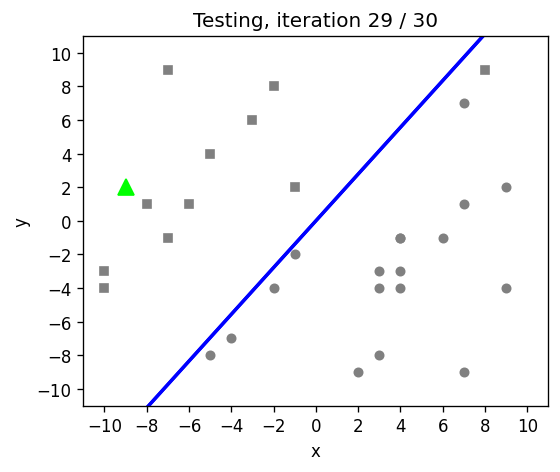

In [283]:
# more extreme rates so we can tell the difference in the animation
lr = 0.3 # start at a high learning rate
cr = 0.9 # faster cooling
dim = 2
w = np.random.rand(dim) # weight

duration = 30 # total iterations (keep it low to keep this fast)
cutoff = round(0.7 * duration) # which proportion are training

# smaller x & y for the ease of drawing
l = -10
h = 10

import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib.animation as animation
fig = plt.figure(figsize = (5, 4), dpi = 120)
ax = plt.subplot(111)

def init():
  global line
  plt.xlim(l - 1, h + 1)
  plt.ylim(l - 1, h + 1)
  tickmarks = np.arange(l, h + 1, step = 2)
  plt.xticks(tickmarks)
  plt.yticks(tickmarks)
  plt.xlabel('x')
  plt.ylabel('y')
  s = -w[0] / w[1] # slope of the line
  line = ax.plot([l, h], [s * l, s * h], 'b-', linewidth = 2)

point = None
old = None

def iteration(t):
  global lr, w, line, point, old
  if line is not None:
    target = line.pop(0) # only draw the current perceptron line, not the past ones
    target.remove()
  if point is not None:
    target = point.pop(0)
    target.remove() # remove highlight
    (d, x, y) = old # leave a gray mark
    if d:
      ax.plot([x], [y], 's', color = 'gray', markersize = 5) # true -> square
    else:
      ax.plot([x], [y], 'o', color = 'gray', markersize = 5) # false -> circle
  # the perceptron is a straight line
  s = -w[0] / w[1] # slope of the line
  line = ax.plot([l, h], [s * l, s * h], 'b-', linewidth = 2)
  i = np.random.randint(l, h, dim) # generate a new input
  x, y = i[0], i[1]
  d = 1 * (x < y) # label the input
  g = 1 * (sum(w * i) > 0) # effect and thresholding together
  ok = d == g
  if ok: # lime-green triangles up when the perceptron gets it right
    point = ax.plot([x], [y], marker = '^', color = 'lime', markersize = 10)
  else: # red triangles that point down when it is wrong
    point = ax.plot([x], [y], marker = 'D', color = 'red', markersize = 10)
  old = (d, x, y)
  stage = 'Training' if t < cutoff else 'Testing'
  plt.title('{:s}, iteration {:d} / {:d}'.format(stage, t, duration))
  if t < cutoff and not ok: # when training, adjust for the next iteration
    a = lr * (d - g)
    lr *= cr
    w += a * i

# increase interval to slow down, reduce to speed up
animation.FuncAnimation(fig, iteration, frames = duration, init_func = init, interval = 700, repeat = False)

**Case B**: Whether (*x*, *y*) lies (roughly) on the unit circle for values [-1, 1]. This means that the *Eucildean distance* of (x, y) to the origin is one. Since we are doing **floating-point** computations, comparing the distance exactly to one is a bad idea, so let's say it needs to be within a margin of error (usually called epsilon in math like this) from one.

First we need to set up the math to know what the labels (the right answers) will be so that we can train and subsequently test.

In [284]:
from math import sqrt, fabs

def eucl(x, y):
  return sqrt(x**2 + y**2)

def unitCircle(x, y, epsilon = 0.01):
  return fabs(1 - eucl(x, y)) < epsilon

Ready to train. We need to reset the weights since this is a whole new task for our little 2D-to-1D perceptron.

In [285]:
inputDimension = 2
weights = np.random.rand(inputDimension) # regenerate
print(weights) # let's see them again

[0.74309026 0.18060294]


In [286]:
low = -1
high = 1
learningRate = 0.15 # reset
training = 1000 # how many times
for t in range(training): # iterate
  input = np.random.uniform(low, high, inputDimension) # a pseudorandom pair of floating-point numbers
  # let the perceptron react
  effect = sum(weights * input) # the inner product of the weights and the input
  # activation function as before
  generatedOutput = 1 * (effect > 0)
  # determine the label (assuming again [x, y] being the input ordering)
  desiredOutput = 1 * unitCircle(input[0], input[1]) # what we want the perceptron to say, as 0 or 1
  if generatedOutput != desiredOutput: # nothing changes here
    adjustment = learningRate * (desiredOutput - generatedOutput)
    learningRate *= coolingRate
    weights += adjustment * input

In [287]:
print(weights)

[-1.28857945e-14 -6.02568158e-13]


The weights look very different, of course, from the x < y case since this is a different task and also different range of input values.

How's the result? Let's test.

In [288]:
testing = 500
score = defaultdict(int) # reset the scorekeeping
for t in range(testing): # the same logic
  input = np.random.uniform(low, high, inputDimension)
  effect = sum(weights * input)
  generatedOutput = 1 * (effect > 0)
  desiredOutput = 1 * unitCircle(input[0], input[1]) # only the right answers differ from Case A
  outcome = (generatedOutput, desiredOutput)
  score[outcome] += 1

print(score)
print(metrics(score))

defaultdict(<class 'int'>, {(0, 0): 232, (1, 0): 256, (1, 1): 7, (0, 1): 5})
{'precision': 0.026615969581749048, 'recall': 0.5833333333333334, 'accuracy': 0.478, 'F1 score': 0.050909090909090904}


What a horrible job! This is because of two things:

*   the task in Case B is not linearly separable in the input space (no straight line is able to tell this apart)  
*   the data set is not balanced: very few of the pairs are actually along the circle since epsilon is small

If we map (*x*, *y*) into polar coordinates (*r*, *a*), and alter the task to be about whether the point is inside the unit circle (instead of on the rim of it), this becomes doable since the imbalance in the data (although still there) is less striking and in the (*r*, *a*) space this actually is a linearly separable task (of whether or not *r* < 1).

In [289]:
from math import atan2

def polar(x, y): # x = r cos a & y = r sin a; solve for r & a to sort out why we do what we do below if interested
  r = sqrt(x**2 + y**2) # note that r ends up being the same as eucl() so we would expect its weight to be positive
  a = atan2(y, x) # our perceptron won't actually need this so we would expects its weight to be near zero
  return np.array([r, a]) # we need inputs to be numpy arrays for compatibility

def inside(x, y, radius = 1): # unit circle, by default
  return eucl(x, y) < radius

In [290]:
inputDimension = 2
weights = np.random.rand(inputDimension) # regenerate
print('before:', weights)

learningRate = 0.15 # reset

for t in range(training): # train
  rawInput = np.random.uniform(low, high, inputDimension) # these are x & y
  input = polar(rawInput[0], rawInput[1]) # these are r & a
  effect = sum(weights * input) # the perceptron only sees r & a
  generatedOutput = 1 * (effect > 0)
  desiredOutput = 1 * inside(rawInput[0], rawInput[1]) # label based on x & y
  if generatedOutput != desiredOutput:
    adjustment = learningRate * (desiredOutput - generatedOutput)
    learningRate *= coolingRate
    weights += adjustment * input

print('after:', weights)

score = defaultdict(int) # reset
for t in range(testing): # largely as before
  rawInput = np.random.uniform(low, high, inputDimension) # x & y
  input = polar(rawInput[0], rawInput[1]) # r & a
  effect = sum(weights * input)
  generatedOutput = 1 * (effect > 0)
  desiredOutput = 1 * inside(rawInput[0], rawInput[1]) # label based on x & y
  outcome = (generatedOutput, desiredOutput)
  score[outcome] += 1

print(score)
print(metrics(score))

before: [0.18608625 0.3548367 ]
after: [9.1527290e-10 4.9531311e-10]
defaultdict(<class 'int'>, {(0, 1): 128, (1, 1): 279, (1, 0): 79, (0, 0): 14})
{'precision': 0.7793296089385475, 'recall': 0.6855036855036855, 'accuracy': 0.586, 'F1 score': 0.7294117647058823}


Much better, although far from perfect.

Now, a let's spice it up to *three-dimensional* **inputs** while the **output** remains *one-dimensional*.

**Case C**: Whether *a*/*b* > *c*.

In [291]:
inputDimension = 3
low = 1 # we do not want negative values here
high = 100

def label(i):
  a, b, c = i[0], i[1], i[2]
  return 1 * (a / b > c)

w = np.random.rand(inputDimension) # generate weights
lr = 0.2
print('before:', w)

for t in range(training): # train
  i = np.random.randint(low, high, inputDimension) # these are a, b, c; integers
  g = 1 * (sum(w * i) > 0)
  d = label(i)
  if g != d:
    a = lr * (d - g)
    lr *= coolingRate
    w += a * i

print('after:', w)

score = defaultdict(int)
for t in range(testing): # test
  i = np.random.randint(low, high, inputDimension) # a, b, c
  g = 1 * (sum(w * i) > 0)
  d = label(i)
  score[(g, d)] += 1

print(score)
print(metrics(score))

before: [0.47628623 0.50588542 0.10748414]
after: [ 10.08076104 -20.10489848 -21.94222007]
defaultdict(<class 'int'>, {(0, 0): 486, (1, 0): 9, (1, 1): 5})
{'precision': 0.35714285714285715, 'recall': 1.0, 'accuracy': 0.982, 'F1 score': 0.5263157894736842}


Look at the results and discuss:


*   what's the balance like?
*   why is it like that?
*   are the results good?

**Case D**: A variant that goes from 4D to 1D: whether *a*/*b* > *c*/*d*.

In [292]:
inputDimension = 4
low = 1
high = 100

def label(i):
  return 1 * ((i[0] / i[1]) > (i[2] / i[3]))

w = np.random.rand(inputDimension) # weights
lr = 0.2
print('before:', w)


for t in range(training): # train
  i = np.random.randint(low, high, inputDimension) # a, b, c, d
  g = 1 * (sum(w * i) > 0)
  d = label(i)
  if g != d:
    a = lr * (d - g)
    lr *= coolingRate
    w += a * i

print('after:', w)

score = defaultdict(int)
for t in range(testing): # test
  i = np.random.randint(low, high, inputDimension) # a, b, c, d
  g = 1 * (sum(w * i) > 0)
  d = label(i)
  score[(g, d)] += 1

print(score)
print(metrics(score))

before: [0.45018228 0.71338965 0.88779068 0.46901389]
after: [ 15.3691823  -14.75991218 -15.6857139   15.23987422]
defaultdict(<class 'int'>, {(1, 1): 231, (0, 0): 234, (1, 0): 15, (0, 1): 20})
{'precision': 0.9390243902439024, 'recall': 0.9203187250996016, 'accuracy': 0.93, 'F1 score': 0.9295774647887323}


Discuss why this task was better suited for the perceptron than the 3D variant that seemed simpler at first glance?

**Case E**: Finally, 1D to multidimensional: converting integersinto binary. This means that we try to train multiple independent perceptrons simultaneously, one for each bit, and convert their concatenated outputs as the "generated output".

For integers between zero and any power of two (non-inclusive) `n = 2**k`, we need `k = floor(log(n, 2)) + 1` bits.

In [397]:
def label(i, l):
  bits = bin(i)[2:] # crop out the 0b prefix
  while len(bits) < l:
    bits = '0' + bits # prepend zeroes as needed
  return bits

print(label(5, 4))

0101


In [294]:
k = 3
n = 2**k
low = 0
high = n - 1

from math import log, floor
print(k, int(floor(log(high, 2)) + 1))

3 3


Let's also put out activation function in a method so that we can substitute it with things fancier than > 0.

In [436]:
def activate(value, epsilon = 0.02):
  return 1 * (value > epsilon) # not zero-zero since it is rather restrictive, but "positive and not very small"

In [452]:
from random import random, randint

def caseE(count): # make it into a method so we can experiment with the effect of k
  high = 2**count - 1 # the biggest integer we can get with that amount of bits
  w = np.random.rand(count) # weights (one per perceptron, k in total)

  # let's try to adapt the parameters to the setting
  lr = 1 / high # the bigger the numbers, the smaller the rate (this is a guess)
  cr = 1 - 1 / (high + 1)
  train = 100 * high
  test = round(0.4 * train)

  for t in range(train): # train
    i = randint(0, high) # an integer
    l = label(i, count) # the bits of the that integer
    for p in range(count): # each perceptron sees the integer and tries to output one specific bit as output
      g = activate(w[p] * i) # the output depends on the current weight and the integer
      d = int(l[p]) # the desired label is that specific bit
      if g != d: # if there is an error, adjust
        w[p] += lr * (d - g) * i # as before (the desired )
        lr *= cr # cooldown

  score = defaultdict(int)
  for t in range(test): # test
    d = randint(0, high)
    b = '' # we need to gather the output bits
    for p in range(count):
      b += str(activate(w[p] * d)) # collect the bits one by one into a string
    g = int(b, 2) # recover the base-10 integer from the collected bits
    score[(g, d)] += 1 # record the score based on i & r

  return score

What's it like?

In [453]:
print(caseE(3))

defaultdict(<class 'int'>, {(5, 1): 34, (7, 7): 44, (7, 3): 36, (7, 2): 35, (0, 0): 30, (7, 6): 35, (7, 5): 35, (7, 4): 31})


Note also that our metrics thinking in terms of false positives and whatnot has become much more complex, so we cannot use the former calculations as such. We can, as a simple alternative, get some idea by calculating how many of the total tests resulted in matching numbers.

In [454]:
def matches(score):
  total = 0
  matching = 0
  for (g, d), count in score.items():
    if g == d:
      matching += count
    total += count
  return matching / total

for attempt in range(5):
  print(matches(caseE(2)))

0.75
0.525
0.7666666666666667
0.6916666666666667
0.48333333333333334


Now, the confusion matrices themselves can get big since we have a lot of options of expected/received answer. It will be easier to interpret at them as such.

We put the desired outputs as rows and the generated outputs as columns.

In [466]:
import pandas as pd

def confusion(score):
  expected = set( [ d for (g, d) in score.keys() ])
  received = set( [ g for (g, d) in score.keys() ])
  rows = dict()
  for d in sorted(list(expected)):
    row = [ score.get((g, d), 0) for g in received ]
    rows[d] = row
  return pd.DataFrame.from_dict(rows, orient = 'index', columns = sorted(list(received)))

results = caseE(4)
print(matches(results))
confusion(results)

0.19166666666666668


,0,8,12,15
0,0,29,0,0
1,36,0,0,0
2,46,0,0,0
3,36,0,0,0
4,38,0,0,0
5,34,0,0,0
6,31,0,0,0
7,31,0,0,0
8,45,0,0,0
9,0,0,32,0


The dataset should be perfectly balanced. Yet, there are very few columns 😞 The perceptrons appear unable to distinguish between the integers.

Why is the model so bad? Are the parameters poorly selected? Is the task not linearly separable?

Let's experiment some more to dig deeper.

In [467]:
for k in range(1, 8):
  print(k, '{:.2f}'.format(matches(caseE(k))))

1 1.00
2 0.53
3 0.24
4 0.21
5 0.10
6 0.05
7 0.02


So, just showing the integer is definitely not enough data for a perceptron to catch on. If you feel like your brain can take more, keep reading for a richer variant. If your brain has gotten enough of perceptrons, close the browser tab --- you have learned a lot already.

So, in the below, black-and-white drawings of digits from zero to nine will be generated pseudorandomly with some noise as 3 x 5 images. Then, the 15 pixels of that image will be fed as input to four independent perceptrons that will be trained to produce 4-bit representations of the integers pictured in the images. This will turn out to be a much easier task for perceptrons.

The template for generating each digit is a combination of "gray", "black", and "white" pixels, where


*   "gray" ones will occasionally be drawn black, sometimes in white
*   "black" ones will almost always be drawn black, rarely in white
*   "white" ones will almost always be drawn white, rarely black

with one template per row (blanks in between for visibility). The 15 characters provide the row-by-row template of the 3 x 5 image.

A five, for example, is

*g* **b** *g*

**b** w w

*g* **b** *g*

w w **b**

*g* **b** *g*

just in one single row.

In [323]:
text = '''g b g b w b b w b b w b g b g
w w g w w b w w b w w b w w g
g b b w w b g b g b w w b b g
g b g w w b g b g w w b g b g
b w g b w b g b b w w b w w g
g b g b w w g b g w w b g b g
g b g b w w b b g b w b g b g
g b b w w b w w b w w b w w g
g b g b w b g b g b w b g b g
g b g b w b g b g w w b g b g
'''
from io import StringIO
template = pd.read_csv(StringIO(text), sep=' ', header = None)
template

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,g,b,g,b,w,b,b,w,b,b,w,b,g,b,g
1,w,w,g,w,w,b,w,w,b,w,w,b,w,w,g
2,g,b,b,w,w,b,g,b,g,b,w,w,b,b,g
3,g,b,g,w,w,b,g,b,g,w,w,b,g,b,g
4,b,w,g,b,w,b,g,b,b,w,w,b,w,w,g
5,g,b,g,b,w,w,g,b,g,w,w,b,g,b,g
6,g,b,g,b,w,w,b,b,g,b,w,b,g,b,g
7,g,b,b,w,w,b,w,w,b,w,w,b,w,w,g
8,g,b,g,b,w,b,g,b,g,b,w,b,g,b,g
9,g,b,g,b,w,b,g,b,g,w,w,b,g,b,g


Best to draw these to understand it better. For that, we need to associate numerical likelihood of "this pixel is black" into. the letter codes

In [326]:
template = template.replace({'b': 0.99, 'g': 0.90, 'w': 0.01})
template

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.90,0.99,0.90,0.99,0.01,0.99,0.99,0.01,0.99,0.99,0.01,0.99,0.90,0.99,0.9
1,0.01,0.01,0.90,0.01,0.01,0.99,0.01,0.01,0.99,0.01,0.01,0.99,0.01,0.01,0.9
2,0.90,0.99,0.99,0.01,0.01,0.99,0.90,0.99,0.90,0.99,0.01,0.01,0.99,0.99,0.9
3,0.90,0.99,0.90,0.01,0.01,0.99,0.90,0.99,0.90,0.01,0.01,0.99,0.90,0.99,0.9
4,0.99,0.01,0.90,0.99,0.01,0.99,0.90,0.99,0.99,0.01,0.01,0.99,0.01,0.01,0.9
5,0.90,0.99,0.90,0.99,0.01,0.01,0.90,0.99,0.90,0.01,0.01,0.99,0.90,0.99,0.9
6,0.90,0.99,0.90,0.99,0.01,0.01,0.99,0.99,0.90,0.99,0.01,0.99,0.90,0.99,0.9
7,0.90,0.99,0.99,0.01,0.01,0.99,0.01,0.01,0.99,0.01,0.01,0.99,0.01,0.01,0.9
8,0.90,0.99,0.90,0.99,0.01,0.99,0.90,0.99,0.90,0.99,0.01,0.99,0.90,0.99,0.9
9,0.90,0.99,0.90,0.99,0.01,0.99,0.90,0.99,0.90,0.01,0.01,0.99,0.90,0.99,0.9


Let's generate a bunch pseudorandomly.

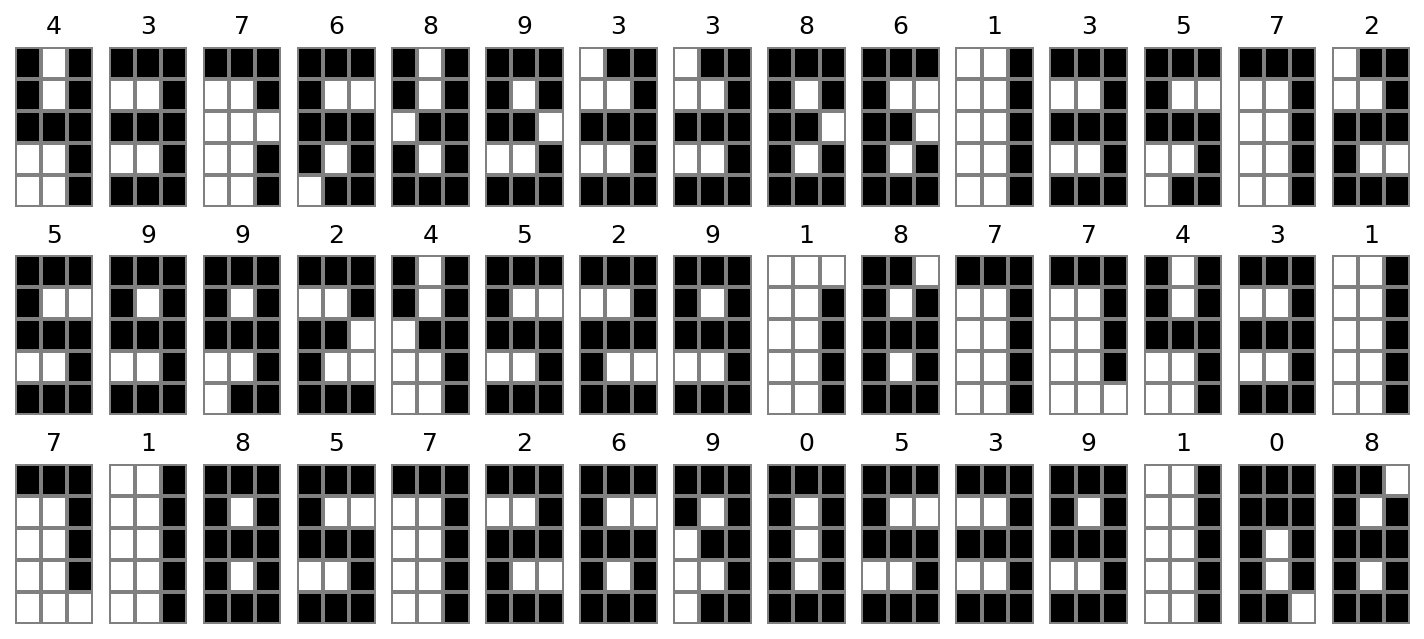

In [375]:
r = 5
c = 3
dim = r * c
w = 15 # how many images side by side
h = 3 # how many rows of images

import matplotlib.cm as cm # need a colormap

f, a = plt.subplots(h, w, figsize = (12, 5), dpi = 150)
plt.subplots_adjust(left = None, bottom = None, right = None, top = None, wspace = None, hspace = 0.3)
for row in range(h):
  for col in range(w):
    d = randint(0, 9) # pick a digit
    pixels = 1 * (np.random.rand(dim) < template.iloc[d])
    img = pixels.values.reshape(r, c) # make it into the 3x5 shape
    a[row, col].pcolormesh(img, edgecolors = 'gray', cmap = cm.Greys)
    a[row, col].set_title(str(d)) # use the "correct digit" as image title
    a[row, col].axis('off')
    a[row, col].invert_yaxis() # in digital images, the origin is top-left (and y axis increases downwards)

So there's definitely finer data available now for the perceptrons to work with than when we fed the integer alone as input. Let's train like this, 15 inputs and 4 outputs.

Note that with four bits, we can also get results 10, 11, 12, 13, 14 & 15, which will never be "correct", so our confusion matrix may have those columns, too.

In [392]:
lr = 0.3
cr = 0.98

score = dict()
count = 4
weights = np.random.rand(count, dim) # 4 perceptrons, each with 15 weights, shoved in a matrix to have just one variable (each row is a perceptron)
print('before', weights)

for t in range(5000): # train (a lot)
    d = randint(0, 9) # pick a digit
    i = 1 * (np.random.rand(dim) < template.iloc[d]) # generate the 15 pixels to represent the digit
    l = '{0:04b}'.format(d) # make a four-bit binary string of the digit
    for p in range(count): # show each perceptron the pixels
        g = 1 * (sum(weights[p, :] * i) > 0) # threholded generated bit
        d = int(l[p]) # this is the bit we wanted
        if d != g: # if mismatch
            weights[p, :] += (lr * (d - g)) * i # update the weight
            lr *= cr # cool it down

print('after', weights)

before [[0.98002062 0.71981076 0.14576703 0.16267066 0.49750473 0.8025275
  0.44296155 0.90459032 0.27799868 0.85462855 0.12235809 0.14993123
  0.95516316 0.98623523 0.96142593]
 [0.60299431 0.30039164 0.51746784 0.85233954 0.7410641  0.34385613
  0.78164316 0.31381101 0.4172286  0.66551561 0.55199209 0.90863732
  0.65718747 0.9876787  0.82151829]
 [0.18501973 0.53409728 0.23359984 0.75141026 0.66113913 0.19448233
  0.02975875 0.36753951 0.8360669  0.53991306 0.38194998 0.65005955
  0.96425075 0.82746766 0.04468784]
 [0.14039745 0.97466748 0.07610027 0.95400699 0.92178624 0.02788952
  0.3874939  0.03626733 0.65145201 0.66416335 0.94487232 0.01738997
  0.7615882  0.70046793 0.57207687]]
after [[ 0.09197468 -0.2098902  -0.64422812  0.4237061   0.49706046  0.35729029
  -0.35425184  0.53042277 -0.27511051  0.08003273  0.1128787  -0.21842553
   0.07916235  0.27764659 -0.05880644]
 [ 0.22606297 -0.09642763  0.00474311  0.23851696  0.73247736 -0.79750276
  -0.13198536 -0.05284697 -0.03100809 

This happened. Were they good things?

In [393]:
score = defaultdict(int)
for t in range(500): # test
    d = randint(0, 9)
    i = 1 * (np.random.rand(dim) < template.iloc[d])
    l = '{0:04b}'.format(d)
    b = ''
    for p in range(count): # gather the bits that the perceptrons produce
        b += str(1 * (sum(weights[p, :] * i) > 0))
    g = int(b, 2) # as base 10
    if t < 10: # see some of them
      print(b, l)
    score[(g, d)] += 1

0110 0110
1000 1000
0101 0101
1000 1000
0010 0010
1000 0100
0011 0011
1001 1001
0001 0001
0100 0100


What's the veredict?

In [394]:
confusion(score)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,38,0,0,0,2,1,0,0,6,0,0,0,0,0,0,0
1,3,34,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0,0,35,0,0,0,0,0,1,0,13,0,0,0,0,0
3,0,1,0,46,0,0,0,1,0,0,0,5,0,0,0,1
4,6,0,0,0,36,0,0,0,4,0,0,0,5,1,0,0
5,0,0,0,0,0,43,0,5,0,0,0,0,0,11,0,4
6,0,0,0,0,6,2,37,0,0,0,0,0,1,0,5,2
7,0,0,0,3,0,1,0,27,0,0,0,0,0,0,0,0
8,6,0,0,0,0,0,0,0,46,0,3,0,0,0,0,0
9,0,40,0,0,0,2,0,0,0,12,0,0,1,2,0,0


Not too shabby 😂

In [468]:
matches(score)

0.708